In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.optim as optim
from Utils.dataset import PreloadedDataset
from tqdm import tqdm

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else "cpu"
device

device(type='cuda')

Loaded MNIST with 60000 samples


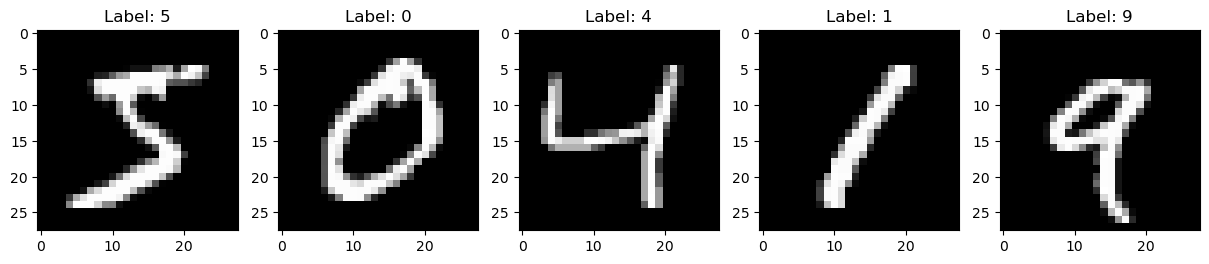

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

VAL_RATIO = 0.2
dataset = datasets.MNIST(root="../Datasets/", train=True, transform=transform, download=False)
train_size = int((1 - VAL_RATIO) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataset = PreloadedDataset.from_dataset(train_dataset, None, device)
val_dataset = PreloadedDataset.from_dataset(val_dataset, None, device)
print(f'Loaded MNIST with {len(dataset)} samples')

# show first samples positives
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axs[i].imshow(np.squeeze(dataset[i][0].numpy()), cmap='gray')
    axs[i].set_title(f"Label: {dataset[i][1]}")
plt.show()

In [68]:
class MLP(nn.Module):
    def __init__(self, in_features, out_features, hidden_features=[]):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_features = hidden_features

        self.layers = nn.ModuleList()
        for h in hidden_features:
            self.layers.append(nn.Linear(in_features, h))
            in_features = h
        self.layers.append(nn.Linear(in_features, out_features))

    def forward(self, x):
        out = [x]
        for layer in self.layers:
            out.append(torch.relu(layer(out[-1])))
        return out


In [96]:
def eval(
    model,
    dataset,
    batch_size=64,
):
    with torch.no_grad():
        dataloader = DataLoader(dataset, batch_size)
        correct = 0
        total = 0
        for x, y in dataloader:
            x = x.flatten(start_dim=1)
            total += len(x)

            out = model(x)[-1]
            pred = torch.argmax(out, dim=1)
            correct += torch.sum(pred == y).item()

    return correct / total

def decov_loss(hiddens):
    Cs = [torch.mm(h.T, h) / (h.shape[0]-1) for h in hiddens]
    Cs = [C - C.diag() for C in Cs]
    decov_loss = 0.5 * sum([C.square().mean() for C in Cs])
    return decov_loss

def train(
    model,
    train_dataset,
    val_dataset,
    optimiser,
    batch_size,
    epochs,
    corr_coeff,
    train_acc,
    val_acc,
    train_losses,
    ce_losses,
    decov_losses,
    eval_every=1,
):

    for epoch in range(epochs):

        dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
        epoch_train_losses = []
        epoch_ce_losses = []
        epoch_decov_losses = []

        loop = tqdm(dataloader, total=len(dataloader), leave=False)
        for x, y in loop:
            if epoch > 0:
                loop.set_description(f"Epoch [{epoch}/{epochs}]")
                loop.set_postfix(train_loss=train_losses[-1], train_acc=train_acc[-1], val_acc=val_acc[-1], ce_loss=ce_losses[-1], decov_loss=decov_losses[-1])

            x = x.flatten(start_dim=1)
            out = model(x)
            loss = F.cross_entropy(out[-1], y)
            decov = corr_coeff * decov_loss(out[:-1])
            epoch_ce_losses.append(loss.item())
            epoch_decov_losses.append(decov.item())
            loss += decov

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_train_losses.append(loss.item())

        if epoch % eval_every == 0:
            train_acc.append(eval(model, train_dataset))
            val_acc.append(eval(model, val_dataset))
            train_losses.append(torch.tensor(epoch_train_losses).mean().item())
            ce_losses.append(torch.tensor(epoch_ce_losses).mean().item())
            decov_losses.append(torch.tensor(epoch_decov_losses).mean().item())

In [105]:
def build_and_train(corr_coeff, steps=10):
    final_vals = []
    for _ in range(steps):
        model = MLP(784, 10, [256, 256, 128]).to(device)
        train_acc = []
        val_acc = []
        train_losses = []
        ce_losses = []
        decov_losses = []

        BATCH_SIZE = 512
        LR = 3e-4
        EPOCHS = 11
        CORR_COEFF = corr_coeff

        optimiser = optim.AdamW(model.parameters(), lr=LR)
        eval_every = 10

        train(
            model,
            train_dataset,
            val_dataset,
            optimiser,
            BATCH_SIZE,
            EPOCHS,
            CORR_COEFF,
            train_acc,
            val_acc,
            train_losses,
            ce_losses,
            decov_losses,
            eval_every,
        )
        final_vals.append(val_acc[-1])

    return np.mean(final_vals), np.std(final_vals)

build_and_train(0.0, steps=5)

KeyboardInterrupt: 

In [100]:
corr_coeffs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
mean_val_accs = []
std_val_accs = []
for c in corr_coeffs:
    mean, std = build_and_train(c, steps=10)
    mean_val_accs.append(mean)
    std_val_accs.append(std)

<ErrorbarContainer object of 3 artists>

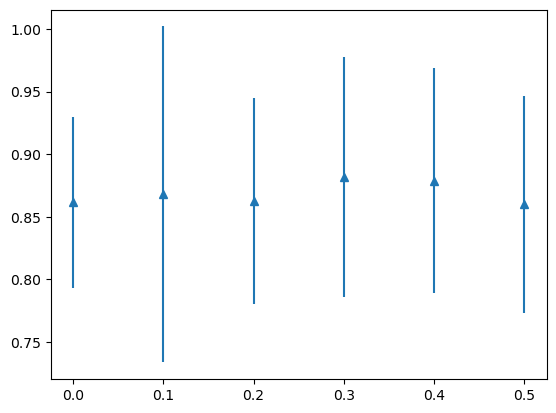

In [101]:
plt.errorbar(corr_coeffs, mean_val_accs, std_val_accs, linestyle='None', marker='^')

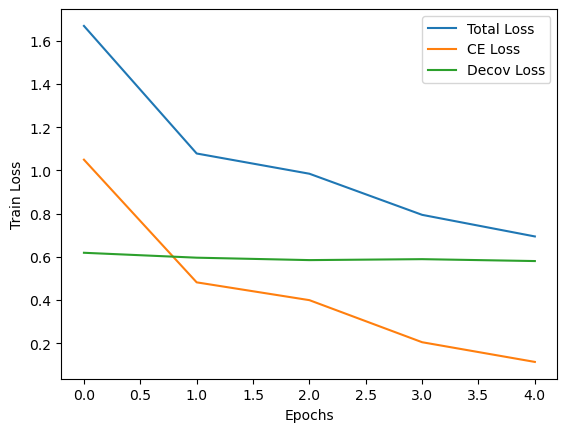

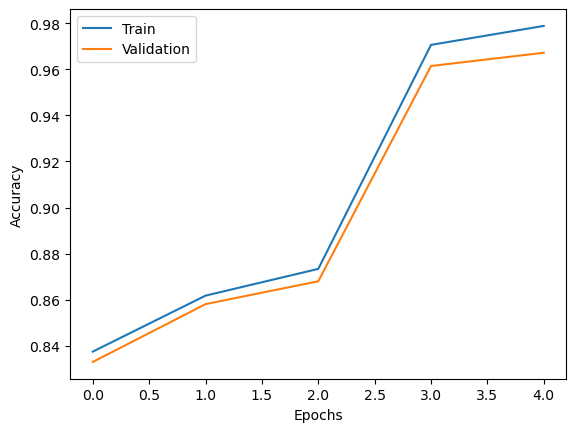

In [90]:
# Plot
epochs = torch.arange(0, len(train_losses))
epochs *= eval_every
plt.plot(epochs, train_losses, label='Total Loss')
plt.plot(epochs, ce_losses, label='CE Loss')
plt.plot(epochs, decov_losses, label='Decov Loss')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.legend()
plt.show()

plt.plot(epochs, train_acc, label='Train')
plt.plot(epochs, val_acc, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
